In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

In [2]:
df = pd.read_csv('BTC-USD-HDATA.csv')
df = df.sort_values('Date').reset_index(drop=True)
df=df.dropna()

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-05-22,235.320999,240.968994,235.059998,240.348007,240.348007,27003000
1,2015-05-23,240.285995,241.024994,238.690994,238.871994,238.871994,14605000
2,2015-05-24,238.975998,241.977997,238.811005,240.953003,240.953003,11508000
3,2015-05-25,240.927002,241.020996,236.636993,237.110001,237.110001,14423900
4,2015-05-26,237.104004,238.242004,235.692001,237.115997,237.115997,16425000
...,...,...,...,...,...,...,...
2553,2022-05-18,30424.478516,30618.716797,28720.271484,28720.271484,28720.271484,31285268319
2554,2022-05-19,28720.359375,30430.751953,28708.955078,30314.333984,30314.333984,33773447707
2555,2022-05-20,30311.119141,30664.976563,28793.605469,29200.740234,29200.740234,30749382605
2556,2022-05-21,29199.859375,29588.869141,29027.394531,29432.226563,29432.226563,17274840442


In [4]:
df.shape

(2558, 7)

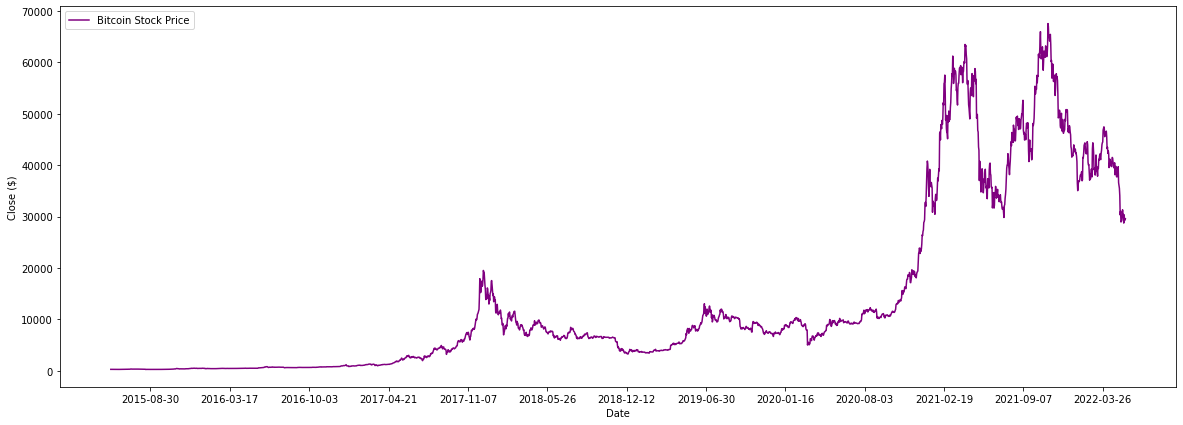

In [5]:
df['Close'] = df['Close'].astype(float)

plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['Close'].values, label = 'Bitcoin Stock Price', color = 'Purple')
plt.xticks(np.arange(100,df.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.legend()
plt.show()

# Data Preprocessing

In [11]:
num_shape = 1800

train = df.iloc[:num_shape, 1:2].values
test = df.iloc[num_shape:, 1:2].values

In [7]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [8]:
X_train = []

#Price on next day
y_train = []

window = 60

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

# Building LSTM Model

In [9]:
# Initializing the Recurrent Neural Network
model = Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [10]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history=model.fit(X_train, y_train, epochs = 50, batch_size = 32);

Epoch 1/50
55/55 [==============================] - 12s 73ms/step - loss: 0.0136
Epoch 2/50
55/55 [==============================] - 4s 73ms/step - loss: 0.0036
Epoch 3/50
55/55 [==============================] - 4s 76ms/step - loss: 0.0030
Epoch 4/50
55/55 [==============================] - 4s 76ms/step - loss: 0.0031
Epoch 5/50
55/55 [==============================] - 4s 74ms/step - loss: 0.0031
Epoch 6/50
55/55 [==============================] - 4s 73ms/step - loss: 0.0026
Epoch 7/50
55/55 [==============================] - 4s 74ms/step - loss: 0.0024
Epoch 8/50
55/55 [==============================] - 4s 74ms/step - loss: 0.0024
Epoch 9/50
55/55 [==============================] - 4s 73ms/step - loss: 0.0021
Epoch 10/50
55/55 [==============================] - 4s 77ms/step - loss: 0.0021
Epoch 11/50
55/55 [==============================] - 5s 92ms/step - loss: 0.0021
Epoch 12/50
55/55 [==============================] - 5s 86ms/step - loss: 0.0023
Epoch 13/50
55/55 [=================

In [12]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [13]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

24/24 [==============================] - 2s 24ms/step


In [14]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 148531711.98988464
MAE: 9655.633789166473
RMSE: 12187.35869620176


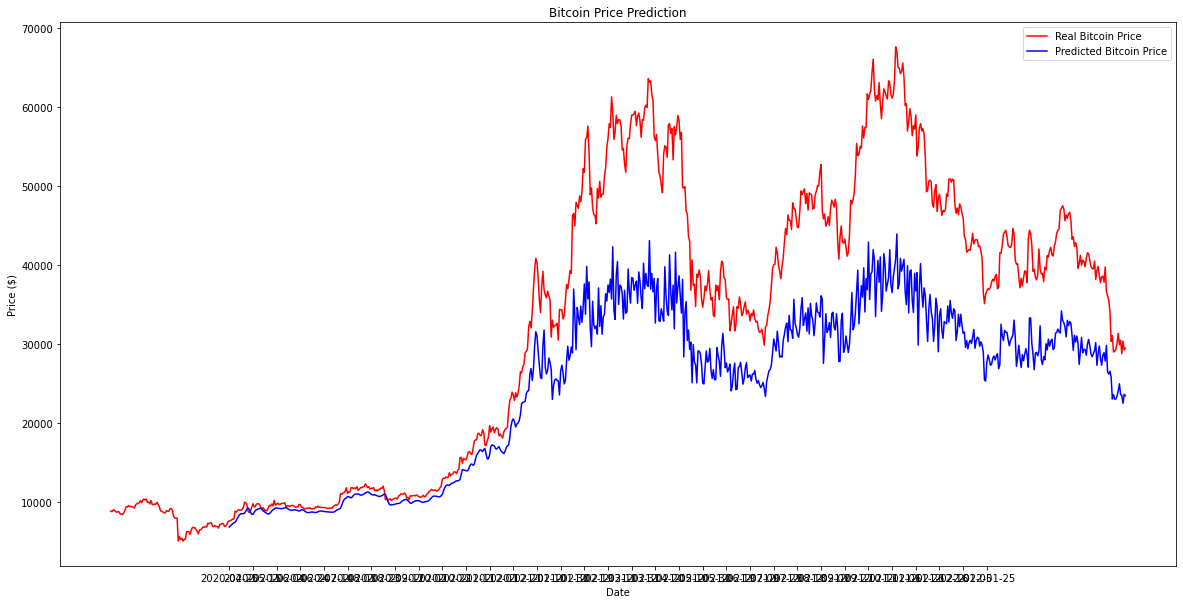

In [15]:
plt.figure(figsize=(20,10))
plt.plot(df['Date'].values[1700:], df_volume[1700:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df['Date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df[1800:].shape[0],20))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# 20 Day Prediction

In [16]:
pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = df.iloc[:, 1:2][1:].values

for j in range(20):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]


24/24 [==============================] - 1s 23ms/step


In [17]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

In [18]:
df_date = df[['Date']]

for h in range(20):
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])
    df_date = df_date.append(df_date_add)
df_date = df_date.reset_index(drop=True)

C:\Users\B.MALLA REDDY\AppData\Local\Temp\ipykernel_20932\3583085181.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(df_date_add)
C:\Users\B.MALLA REDDY\AppData\Local\Temp\ipykernel_20932\3583085181.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(df_date_add)
C:\Users\B.MALLA REDDY\AppData\Local\Temp\ipykernel_20932\3583085181.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(df_date_add)
C:\Users\B.MALLA REDDY\AppData\Local\Temp\ipykernel_20932\3583085181.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_date = df_date.append(df_date_add)
C:\Users

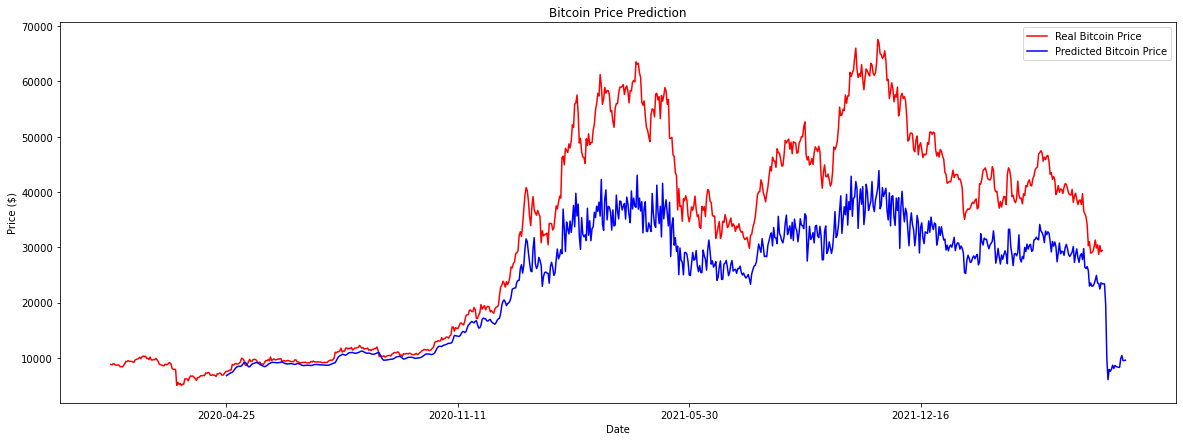

In [19]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values[1700:], df_volume[1700:], color = 'red', label = 'Real Bitcoin Price')
plt.plot(df_date['Date'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Bitcoin Price')
plt.xticks(np.arange(100,df[1700:].shape[0],200))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()
